In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

In [10]:
trainData = open('../../../dataFinal/preprocessed_train_text.txt', 'r').readlines()
trainLabels = open('../../../dataFinal/finalTrainLabels.labels', 'r').readlines()
testData = open('../../../dataFinal/preprocessed_test_text.txt', 'r').readlines()
testLabels = open('../../../dataFinal/finalTestLabels.labels', 'r').readlines()
validData = open('../../../dataFinal/preprocessed_trial_text.txt', 'r').readlines()
validLabels = open('../../../dataFinal/finalDevLabels.labels', 'r').readlines()

In [11]:
for i in tqdm(range(len(trainData))):
    trainData[i] = trainData[i][:-1]
for i in tqdm(range(len(testData))):
    testData[i] = testData[i][:-1]
for i in tqdm(range(len(validData))):
    validData[i] = validData[i][:-1]

100%|██████████| 10009/10009 [00:00<00:00, 930342.81it/s]


In [12]:
for i in tqdm(range(len(trainLabels))):
    trainLabels[i] = int(trainLabels[i])
for i in tqdm(range(len(testLabels))):
    testLabels[i] = int(testLabels[i])
for i in tqdm(range(len(validLabels))):
    validLabels[i] = int(validLabels[i])

100%|██████████| 10008/10008 [00:00<00:00, 794770.42it/s]


In [13]:
trainData = trainData[1:]
testData = testData[1:]
validData = validData[1:]

In [14]:
trainLabels = np.array(trainLabels)
testLabels = np.array(testLabels)
validLabels = np.array(validLabels)
trainLabels = trainLabels.reshape((-1, ))
testLabels = testLabels.reshape((-1, ))
validLabels = validLabels.reshape((-1, ))

In [15]:
gloveEmbs = open('../../glove.twitter.27B.200d.txt', encoding='utf-8')

In [16]:
embeddings = {}
for line in gloveEmbs:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings[word] = coefs
gloveEmbs.close()

In [17]:
def embeddingOutput(X):
    """
    X: input matrix
    """
    maxLen = 10
    embDim = 200
    embOutput = np.zeros((len(X), maxLen, embDim))
    for i in range(len(X)):
        X[i] = X[i].split()
        for j in range(maxLen):
            try:
                embOutput[i][j] = embeddings[X[i][j].lower()]
            except:
                embOutput[i][j] = np.zeros((embDim, ))
    return embOutput

In [18]:
embeddingMatrixTrain = embeddingOutput(trainData)
embeddingMatrixTest = embeddingOutput(testData)
embeddingMatrixVal = embeddingOutput(validData)

In [20]:
from keras.utils import np_utils

In [21]:
trainLabels = np_utils.to_categorical(trainLabels, 20)
testLabels = np_utils.to_categorical(testLabels, 20)
validLabels = np_utils.to_categorical(validLabels, 20)

In [22]:
from keras.models import Sequential
from keras.layers import LSTM, RNN, Dense, Dropout, Embedding, RNN, Bidirectional, Add, merge, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [23]:
from keras import layers
from tensorflow import keras

In [71]:
input = keras.Input(shape=(10, 200))
x = Bidirectional(LSTM(128, return_sequences=True))(input)
x = Bidirectional(LSTM(128))(x)
outputs = Dense(20, activation='softmax')(x)
model = keras.Model(input, outputs)
model.summary()
model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])
lossCheck = ModelCheckpoint('bilstmModelLoss.h5', monitor='val_loss', verbose=True, save_best_only=True)
accCheck = ModelCheckpoint('bilstmModelAcc.h5', monitor='val_accuracy', verbose=True, save_best_only=True)
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=True)
hist = model.fit(embeddingMatrixTrain, trainLabels, epochs=50, batch_size=128,
                 validation_data=(embeddingMatrixVal, validLabels), shuffle=True, callbacks=[lossCheck, accCheck, earlyStopping])


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 10, 200)]         0         
                                                                 
 bidirectional_28 (Bidirecti  (None, 10, 256)          336896    
 onal)                                                           
                                                                 
 bidirectional_29 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                                 
 dense_14 (Dense)            (None, 20)                5140      
                                                                 
Total params: 736,276
Trainable params: 736,276
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
546/547 [============================>.] -

In [72]:
model.evaluate(embeddingMatrixTest, testLabels)
model.load_weights('bilstmModelLoss.h5')
model.evaluate(embeddingMatrixTest, testLabels)
model.load_weights('bilstmModelAcc.h5')
model.evaluate(embeddingMatrixTest, testLabels)

625/625 [==============================] - 5s 8ms/step - loss: 2.3531 - accuracy: 0.3172


[2.353130578994751, 0.3172000050544739]

In [74]:
model.load_weights('bilstmModelLoss.h5')
model.evaluate(embeddingMatrixTest, testLabels)

625/625 [==============================] - 5s 8ms/step - loss: 2.3177 - accuracy: 0.3201


[2.317739248275757, 0.32010000944137573]

In [24]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

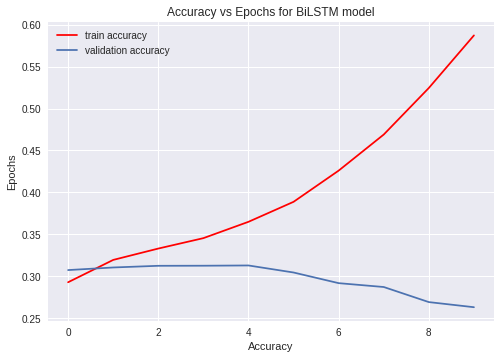

In [82]:
plt.plot(hist.history['accuracy'], label='train accuracy', c='red')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.legend()
plt.title('Accuracy vs Epochs for BiLSTM model')
plt.show()

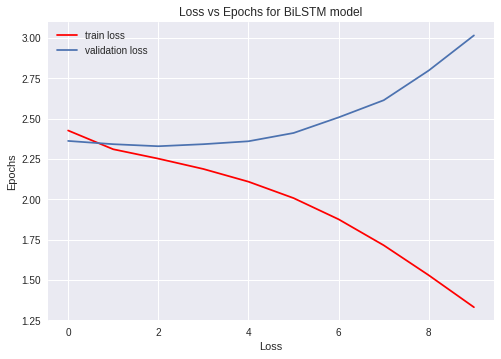

In [83]:
plt.plot(hist.history['loss'], label='train loss', c='red')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.legend()
plt.title('Loss vs Epochs for BiLSTM model')
plt.show()

In [25]:
from sklearn.metrics import classification_report

In [85]:
preds = model.predict(embeddingMatrixTest)
preds = np.argmax(preds, axis=1)
finalLabels = np.argmax(testLabels, axis=1)
cr = classification_report(finalLabels, preds)
print(cr)

              precision    recall  f1-score   support

           0       0.32      0.69      0.43      4312
           1       0.25      0.19      0.22      2022
           2       0.33      0.52      0.40      1955
           3       0.21      0.03      0.06      1099
           4       0.38      0.45      0.41      1246
           5       0.14      0.01      0.01       786
           6       0.27      0.09      0.14       809
           7       0.32      0.18      0.23       928
           8       0.21      0.04      0.07       669
           9       0.18      0.01      0.01       569
          10       0.12      0.04      0.05       595
          11       0.45      0.41      0.43       696
          12       0.36      0.45      0.40       546
          13       0.00      0.00      0.00       492
          14       0.13      0.03      0.05       536
          15       0.24      0.12      0.16       498
          16       0.29      0.02      0.04       492
          17       0.61    

In [86]:
preds = model.predict(embeddingMatrixVal)
preds = np.argmax(preds, axis=1)
finalLabels = np.argmax(validLabels, axis=1)
cr = classification_report(finalLabels, preds)
print(cr)

              precision    recall  f1-score   support

           0       0.31      0.69      0.43      2156
           1       0.25      0.18      0.21      1011
           2       0.34      0.52      0.41       978
           3       0.24      0.04      0.06       549
           4       0.35      0.44      0.39       624
           5       0.17      0.01      0.02       393
           6       0.20      0.06      0.09       405
           7       0.30      0.16      0.21       465
           8       0.14      0.03      0.05       335
           9       0.25      0.01      0.01       285
          10       0.13      0.04      0.06       298
          11       0.45      0.42      0.43       348
          12       0.30      0.38      0.34       273
          13       1.00      0.00      0.01       246
          14       0.05      0.01      0.02       269
          15       0.19      0.10      0.13       250
          16       0.31      0.04      0.07       246
          17       0.58    

In [87]:
preds = model.predict(embeddingMatrixTrain)
preds = np.argmax(preds, axis=1)
finalLabels = np.argmax(trainLabels, axis=1)
cr = classification_report(finalLabels, preds)
print(cr)

              precision    recall  f1-score   support

           0       0.33      0.72      0.45     15090
           1       0.33      0.23      0.27      7076
           2       0.37      0.57      0.45      6842
           3       0.29      0.05      0.09      3842
           4       0.42      0.51      0.46      4363
           5       0.20      0.01      0.02      2751
           6       0.29      0.09      0.13      2831
           7       0.38      0.23      0.28      3250
           8       0.26      0.05      0.09      2341
           9       0.38      0.01      0.03      1992
          10       0.21      0.06      0.09      2083
          11       0.50      0.50      0.50      2433
          12       0.38      0.48      0.43      1908
          13       0.39      0.00      0.01      1722
          14       0.19      0.04      0.07      1878
          15       0.30      0.16      0.21      1745
          16       0.31      0.03      0.06      1721
          17       0.59    

In [89]:
input = keras.Input(shape=(10, 200))
x = Bidirectional(LSTM(128, return_sequences=True))(input)
x = Bidirectional(LSTM(128))(x)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(128, return_sequences=True))(input)
x = Bidirectional(LSTM(128))(x)
x = Dropout(0.3)(x)
x = Dense(100)(x)
x = Dropout(0.5)(x)
outputs = Dense(20, activation='softmax')(x)
model = keras.Model(input, outputs)
model.summary()
model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])
lossCheck = ModelCheckpoint('bilstmModelLoss1.h5', monitor='val_loss', verbose=True, save_best_only=True)
accCheck = ModelCheckpoint('bilstmModelAcc1.h5', monitor='val_accuracy', verbose=True, save_best_only=True)
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=True)
hist = model.fit(embeddingMatrixTrain, trainLabels, epochs=50, batch_size=128,
                 validation_data=(embeddingMatrixVal, validLabels), shuffle=True, callbacks=[lossCheck, accCheck, earlyStopping])

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 10, 200)]         0         
                                                                 
 bidirectional_36 (Bidirecti  (None, 10, 256)          336896    
 onal)                                                           
                                                                 
 bidirectional_37 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 100)               25700     
                                                                 
 dropout_18 (Dropout)        (None, 100)               0  

In [90]:
model.evaluate(embeddingMatrixTest, testLabels)
model.load_weights('bilstmModelLoss1.h5')
model.evaluate(embeddingMatrixTest, testLabels)
model.load_weights('bilstmModelAcc1.h5')
model.evaluate(embeddingMatrixTest, testLabels)

625/625 [==============================] - 5s 8ms/step - loss: 2.3271 - accuracy: 0.3196


[2.327110767364502, 0.31964999437332153]

In [26]:
input = keras.Input(shape=(10, 200))
x = Bidirectional(LSTM(128, return_sequences=True))(input)
x = Bidirectional(LSTM(128))(x)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(128, return_sequences=True))(input)
x = Bidirectional(LSTM(128))(x)
x = Dropout(0.3)(x)
x = Dense(100)(x)
x = Dropout(0.5)(x)
outputs = Dense(20, activation='softmax')(x)
model = keras.Model(input, outputs)
model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])

In [27]:
model.load_weights('bilstmModelLoss1.h5')
model.evaluate(embeddingMatrixTest, testLabels)

625/625 [==============================] - 9s 8ms/step - loss: 2.3227 - accuracy: 0.3236


[2.322709560394287, 0.32359999418258667]

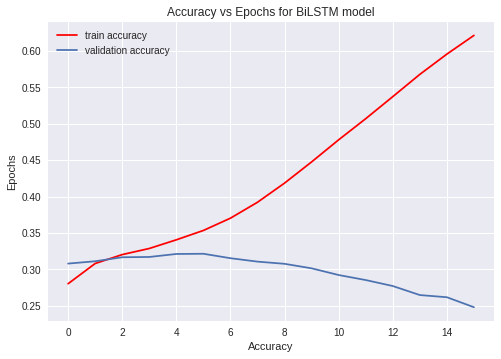

In [92]:
plt.plot(hist.history['accuracy'], label='train accuracy', c='red')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.legend()
plt.title('Accuracy vs Epochs for BiLSTM model')
plt.show()

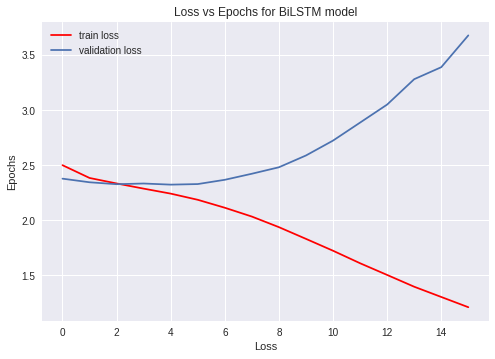

In [93]:
plt.plot(hist.history['loss'], label='train loss', c='red')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.legend()
plt.title('Loss vs Epochs for BiLSTM model')
plt.show()

In [94]:
preds = model.predict(embeddingMatrixTest)
preds = np.argmax(preds, axis=1)
finalLabels = np.argmax(testLabels, axis=1)
cr = classification_report(finalLabels, preds)
print(cr)

              precision    recall  f1-score   support

           0       0.32      0.73      0.44      4312
           1       0.28      0.13      0.18      2022
           2       0.30      0.59      0.39      1955
           3       0.25      0.01      0.02      1099
           4       0.36      0.46      0.41      1246
           5       0.14      0.01      0.02       786
           6       0.21      0.10      0.13       809
           7       0.31      0.19      0.24       928
           8       0.42      0.02      0.04       669
           9       0.24      0.02      0.04       569
          10       0.06      0.00      0.01       595
          11       0.56      0.37      0.45       696
          12       0.31      0.48      0.38       546
          13       0.33      0.00      0.00       492
          14       0.12      0.00      0.01       536
          15       0.30      0.08      0.13       498
          16       0.24      0.02      0.04       492
          17       0.59    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [95]:
preds = model.predict(embeddingMatrixVal)
preds = np.argmax(preds, axis=1)
finalLabels = np.argmax(validLabels, axis=1)
cr = classification_report(finalLabels, preds)
print(cr)

              precision    recall  f1-score   support

           0       0.31      0.73      0.44      2156
           1       0.28      0.12      0.17      1011
           2       0.30      0.59      0.40       978
           3       0.27      0.01      0.02       549
           4       0.37      0.45      0.41       624
           5       0.10      0.01      0.01       393
           6       0.22      0.08      0.12       405
           7       0.30      0.19      0.24       465
           8       0.25      0.01      0.02       335
           9       0.25      0.02      0.03       285
          10       0.18      0.01      0.01       298
          11       0.55      0.37      0.44       348
          12       0.30      0.44      0.36       273
          13       0.00      0.00      0.00       246
          14       0.00      0.00      0.00       269
          15       0.16      0.04      0.07       250
          16       0.27      0.03      0.06       246
          17       0.58    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
preds = model.predict(embeddingMatrixTrain)
preds = np.argmax(preds, axis=1)
finalLabels = np.argmax(trainLabels, axis=1)
cr = classification_report(finalLabels, preds)
print(cr)

              precision    recall  f1-score   support

           0       0.33      0.77      0.46     15090
           1       0.40      0.18      0.25      7076
           2       0.34      0.67      0.45      6842
           3       0.44      0.03      0.05      3842
           4       0.43      0.54      0.48      4363
           5       0.23      0.02      0.04      2751
           6       0.27      0.10      0.15      2831
           7       0.43      0.27      0.34      3250
           8       0.54      0.02      0.05      2341
           9       0.38      0.04      0.07      1992
          10       0.49      0.02      0.04      2083
          11       0.66      0.47      0.55      2433
          12       0.37      0.55      0.45      1908
          13       0.33      0.00      0.00      1722
          14       0.24      0.00      0.01      1878
          15       0.43      0.12      0.19      1745
          16       0.33      0.03      0.05      1721
          17       0.59    

In [34]:
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix

In [142]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontproperties=fontprop)
    plt.yticks(tick_marks, classes, fontproperties=fontprop)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [143]:
cm = confusion_matrix(finalLabels, preds)

In [144]:
from emoji import emojize
import emoji
import matplotlib.font_manager as fm
from matplotlib import ft2font
from matplotlib.font_manager import ttfFontProperty

In [145]:
fpath = 'TwitterColorEmoji-SVGinOT.ttf'
fprop = fm.FontProperties(fname=fpath)

In [99]:
font = ft2font.FT2Font(fpath)
fprop = fm.FontProperties(fname=fpath)

In [100]:
ttfFontProp = ttfFontProperty(font)

In [102]:
fontprop = fm.FontProperties(family='sans-serif',
                            fname=ttfFontProp.fname,
                            size=12,
                            stretch=ttfFontProp.stretch,
                            style=ttfFontProp.style,
                            variant=ttfFontProp.variant,
                            weight=ttfFontProp.weight)

In [147]:
mapping = {0:'\U00002764\U0000FE0F',1:'\U0001F60D',2:'\U0001F602',3:'\U0001F495',4:'\U0001F525', 5:'\U0001F60A',6:'\U0001F60E',7:'\U00002728',8:'\U0001F499',9:'\U0001F618',10:'\U0001F4F7',11:'\U0001F1FA\U0001F1F8',12:'\U00002600\U0000FE0F',13:'\U0001F49C',14:'\U0001F609',15:'\U0001F4AF',16:'\U0001F601',17:'\U0001F384',18:'\U0001F4F8',19:'\U0001F61C'}

In [148]:
emojis = [(mapping[i]) for i in mapping]

In [149]:
emojis

['❤️',
 '😍',
 '😂',
 '💕',
 '🔥',
 '😊',
 '😎',
 '✨',
 '💙',
 '😘',
 '📷',
 '🇺🇸',
 '☀️',
 '💜',
 '😉',
 '💯',
 '😁',
 '🎄',
 '📸',
 '😜']

In [150]:
import matplotlib

Confusion matrix, without normalization
[[11580   487  1235    32   426    31    97   200     8    37     4   142
    334     0     0    50    15   332    80     0]
 [ 4093  1263   858    12   210    22    65   151     3     9     6    37
    189     0     0     5     6   104    43     0]
 [ 1494   137  4555     1   299    15    47    38     2     5     3    48
     66     0     2    16     5    68    41     0]
 [ 2887   125   294   102    77     9    23    88     3    17     2    20
    100     2     1    14     5    56    17     0]
 [  967    98   592     2  2368     2    71    68     1     6     0    19
     51     0     2    42     0    25    49     0]
 [ 1487   152   543     0   100    67    57    55     4     6     1    37
    122     0     4    11    26    53    26     0]
 [ 1026   119   648     2   294    14   297    64     2     4     1    37
    237     0     5    21     1    24    35     0]
 [ 1295   117   317     9   215    13    48   890     2     3     5    26
    105    

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 108 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 112 missing from current font.
  font.set_text(s, 0.0, flags=flags)


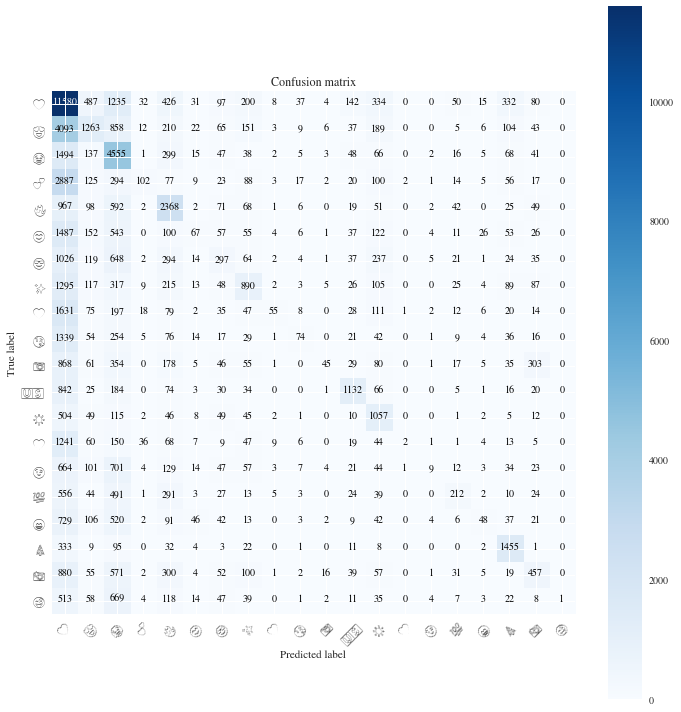

In [151]:
plot_confusion_matrix(cm, classes=emojis)

Confusion matrix, without normalization
[[11580   487  1235    32   426    31    97   200     8    37     4   142
    334     0     0    50    15   332    80     0]
 [ 4093  1263   858    12   210    22    65   151     3     9     6    37
    189     0     0     5     6   104    43     0]
 [ 1494   137  4555     1   299    15    47    38     2     5     3    48
     66     0     2    16     5    68    41     0]
 [ 2887   125   294   102    77     9    23    88     3    17     2    20
    100     2     1    14     5    56    17     0]
 [  967    98   592     2  2368     2    71    68     1     6     0    19
     51     0     2    42     0    25    49     0]
 [ 1487   152   543     0   100    67    57    55     4     6     1    37
    122     0     4    11    26    53    26     0]
 [ 1026   119   648     2   294    14   297    64     2     4     1    37
    237     0     5    21     1    24    35     0]
 [ 1295   117   317     9   215    13    48   890     2     3     5    26
    105    

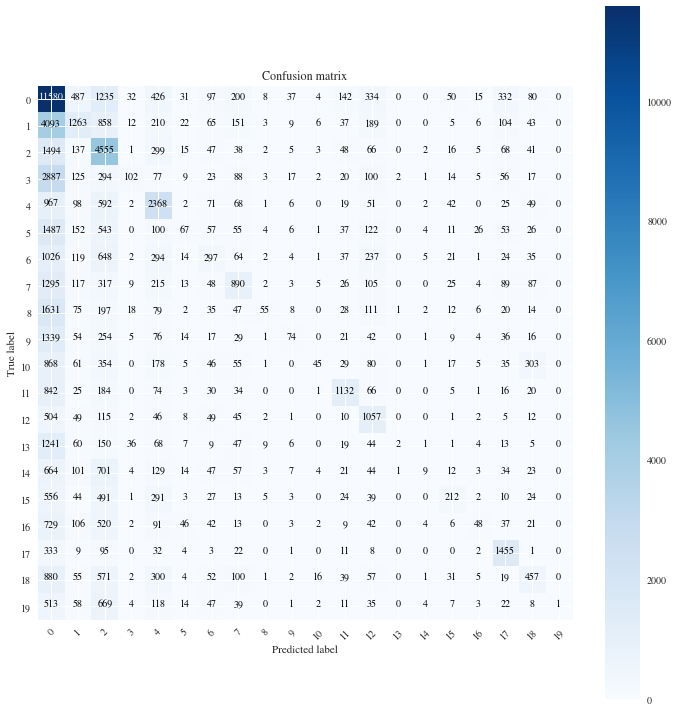

In [91]:
plot_confusion_matrix(cm, classes=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

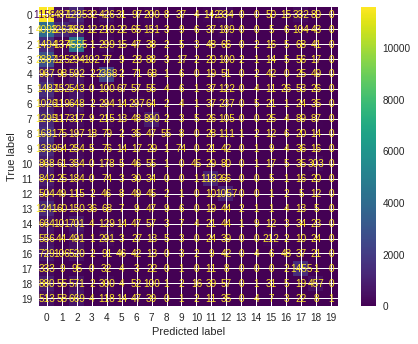

In [110]:
ConfusionMatrixDisplay.from_predictions(finalLabels, preds, labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

In [67]:
input = keras.Input(shape=(10, 200))
x = Bidirectional(LSTM(128, return_sequences=True))(input)
x = Bidirectional(LSTM(128))(x)
x = Dropout(0.6)(x)
x = Bidirectional(LSTM(64, return_sequences=True))(input)
x = Bidirectional(LSTM(64))(x)
x = Dropout(0.6)(x)
x = Bidirectional(LSTM(32, return_sequences=True))(input)
x = Bidirectional(LSTM(32))(x)
x = Dropout(0.5)(x)
x = Dense(100)(x)
x = Dropout(0.5)(x)
x = Dense(50)(x)
x = Dropout(0.5)(x)
outputs = Dense(20, activation='softmax')(x)
model = keras.Model(input, outputs)
model.summary()
model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])
lossCheck = ModelCheckpoint('bilstmModelLoss.h5', monitor='val_loss', verbose=True, save_best_only=True)
accCheck = ModelCheckpoint('bilstmModelAcc.h5', monitor='val_accuracy', verbose=True, save_best_only=True)
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=True)
hist = model.fit(embeddingMatrixTrain, trainLabels, epochs=50, batch_size=256,
                 validation_data=(embeddingMatrixVal, validLabels), shuffle=True, callbacks=[lossCheck, accCheck, earlyStopping])


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 10, 200)]         0         
                                                                 
 bidirectional_24 (Bidirecti  (None, 10, 64)           59648     
 onal)                                                           
                                                                 
 bidirectional_25 (Bidirecti  (None, 64)               24832     
 onal)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 100)               6500      
                                                                 
 dropout_11 (Dropout)        (None, 100)               0   

In [68]:
model.evaluate(embeddingMatrixTest, testLabels)
model.load_weights('bilstmModelLoss.h5')
model.evaluate(embeddingMatrixTest, testLabels)
model.load_weights('bilstmModelAcc.h5')
model.evaluate(embeddingMatrixTest, testLabels)

625/625 [==============================] - 4s 7ms/step - loss: 2.3673 - accuracy: 0.3126


[2.3673312664031982, 0.31255000829696655]